# SPECTRAL

In [1]:
import os
import copy
import math
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
import torchmetrics.image.fid as fid
import lightning as L
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms as transforms
from pathlib import Path
from typing import Optional
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torchdyn.core import NeuralODE
from lightning.pytorch import Trainer, seed_everything
from torchvision import datasets
from torchvision.transforms import ToPILImage, Resize, InterpolationMode
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
from time import time
from PIL import Image

from jump_wtf.data.samplers import TimeGroupedSampler
from jump_wtf.models.unet_wrapper import UNetWrapperKoopman
from jump_wtf.models.autoencoder import Autoencoder_unet
from jump_wtf.models.model import Model
from jump_wtf.operators.generic import GenericOperator_state
from jump_wtf.data.datamodule import DynamicsDataModule
from jump_wtf.losses.koopman_loss import loss
from jump_wtf.utils.sampling import sample_efficient
from jump_wtf.utils.plot import sample_efficient_plot
from jump_wtf.utils.fid import FIDTrainCallback, FIDValCallback, compute_real_stats

# force only GPU 0 to be visible to CUDA
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
dynamics = UNetWrapperKoopman(
        dim=(1, 28, 28), 
        num_channels=64, 
        num_res_blocks=2,
        num_heads=4,
    ).to("cpu")
dynamics.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_otcfm_step-30000.pt"))

# dynamics = UNetWrapperKoopman(
#         dim=(1, 28, 28), 
#         num_channels=32, 
#         num_res_blocks=1,
#         num_heads=1,
#     ).to("cpu")
# dynamics.load_state_dict(torch.load("assets/unet_dynamics/fashion_mnist_full_otcfm_step-25000.pt"))

# dynamics = UNetWrapperKoopman(
#         dim=(1, 28, 28), 
#         num_channels=32, 
#         num_res_blocks=1,
#         num_heads=1,
#     ).to("cpu")
# dynamics.load_state_dict(torch.load("assets/unet_dynamics/mnist_full_otcfm_step-20000.pt"))

# dynamics = UNetWrapperKoopman(
#         dim=(1, 28, 28), 
#         num_channels=32, 
#         num_res_blocks=1,
#         num_heads=1,
#     ).to("cpu")
# dynamics.load_state_dict(torch.load("assets/unet_dynamics/mnist_full_otcfm_step-20.pt"))

/tmp/ipykernel_1040814/256727811.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dynamics.load_state_dict(torch.load("assets/unet_dynamics/toronto_face_toronto_face_otcf

<All keys matched successfully>

In [3]:
traj = torch.load("assets/dynamics_datasets/intermediate_traj/toronto_face_toronto_face_otcfm_step-30000_traj_ema_100.pth")
# traj = torch.load("assets/dynamics_datasets/intermediate_traj/fashion_mnist_full_otcfm_step-25000_traj_ema_100.pth")
# traj = torch.load("assets/dynamics_datasets/intermediate_traj/mnist_full_otcfm_step-20000_traj_ema_100.pth")
# traj = torch.load("assets/dynamics_datasets/intermediate_traj/mnist_full_otcfm_step-20_traj_ema_100.pth")

/tmp/ipykernel_1040814/2665476478.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj = torch.load("assets/dynamics_datasets/intermediate_traj/toronto_face_toronto_face

In [4]:
traj.shape

torch.Size([100, 20000, 1, 28, 28])

In [5]:
#hyper
import geotorch 
#with koop_reg
#with vae loss 
n_epochs = 1
batch_size = 64
#num_res_blocks = 3
#channels = 128
num_res_blocks = 1
channels = 32
datasize = 240000
hidden_layer = 10
output_dim = 200 
feature_dim = 2
autoencoder_lr=0.001
op = GenericOperator_state
#op = Orthogonal
#op = LieModule
lie_lr=0.0001
warmup_step = 10

lr_scheduler="ReduceLROnPlateau"
energy_bool = False
vae_loss = False
gamma = 0.99
delta_t = 0.01
decode_predict_bool=True
koop_reg_bool = False 
period = 10
num_iter = 100
multistep = False
time_dep = True
loss_function = nn.MSELoss()
if time_dep == True:
    feature_dim+=1

device="cuda"

In [6]:
path = "logs/toronto_face/toronto_face/20250511-230311/checkpoints/best-fid-train-step=91300-fid_train=109.635.ckpt"

ae = Autoencoder_unet(
        dim=(1, 28, 28),            # wrapper.dim
        num_channels=64,            # wrapper.num_channels
        num_res_blocks=2,           # wrapper.num_res_blocks
        channel_mult=[1, 2, 2],     # wrapper.channel_mult
        num_heads=4,                # wrapper.num_heads
        num_head_channels=64,       # wrapper.num_head_channels
        attention_resolutions="16", # wrapper.attention_resolutions
        dropout=0,                # wrapper.dropout
        learn_sigma=False,          # wrapper.learn_sigma
        class_cond=False,           # wrapper.class_cond
        use_checkpoint=False,       # wrapper.use_checkpoint
        use_fp16=False,             # wrapper.use_fp16
        use_new_attention_order=False,
    )

# path = "logs/fashion_mnist/full/20250515-205324/checkpoints/best-fid-train-step=12600-fid_train=97.618.ckpt"

# ae = Autoencoder_unet(
#         dim=(1, 28, 28),            # wrapper.dim
#         num_channels=32,            # wrapper.num_channels
#         num_res_blocks=1,           # wrapper.num_res_blocks
#         channel_mult=[1, 2, 2],     # wrapper.channel_mult
#         num_heads=1,                # wrapper.num_heads
#         num_head_channels=-1,       # wrapper.num_head_channels
#         attention_resolutions="14,7", # wrapper.attention_resolutions
#         dropout=0,                  # wrapper.dropout
#         learn_sigma=False,          # wrapper.learn_sigma
#         class_cond=False,           # wrapper.class_cond
#         use_checkpoint=False,       # wrapper.use_checkpoint
#         use_fp16=False,             # wrapper.use_fp16
#         use_new_attention_order=False,
#     )

# path = "logs/mnist/full/20250520-003325/checkpoints/best-fid-train-step=50000-fid_train=36.924.ckpt"

# ae = Autoencoder_unet(
#         dim=(1, 28, 28),            # wrapper.dim
#         num_channels=32,            # wrapper.num_channels
#         num_res_blocks=1,           # wrapper.num_res_blocks
#         channel_mult=[1, 2, 2],     # wrapper.channel_mult
#         num_heads=1,                # wrapper.num_heads
#         num_head_channels=-1,       # wrapper.num_head_channels
#         attention_resolutions="14,7", # wrapper.attention_resolutions
#         dropout=0,                # wrapper.dropout
#         learn_sigma=False,          # wrapper.learn_sigma
#         class_cond=False,           # wrapper.class_cond
#         use_checkpoint=False,       # wrapper.use_checkpoint
#         use_fp16=False,             # wrapper.use_fp16
#         use_new_attention_order=False,
#     )

# path = "best-fid-train-step=3840-fid_train=31.586.ckpt"

# ae = Autoencoder_unet(
#         dim=(1, 28, 28),            # wrapper.dim
#         num_channels=32,            # wrapper.num_channels
#         num_res_blocks=1,           # wrapper.num_res_blocks
#         channel_mult=[1, 2, 2],     # wrapper.channel_mult
#         num_heads=1,                # wrapper.num_heads
#         num_head_channels=-1,       # wrapper.num_head_channels
#         attention_resolutions="16", # wrapper.attention_resolutions
#         dropout=0,                # wrapper.dropout
#         learn_sigma=False,          # wrapper.learn_sigma
#         class_cond=False,           # wrapper.class_cond
#         use_checkpoint=False,       # wrapper.use_checkpoint
#         use_fp16=False,             # wrapper.use_fp16
#         use_new_attention_order=False,
#     )

model_generic = Model.load_from_checkpoint(path,dynamics=dynamics, autoencoder = ae,
                           koopman=op(1569), loss_function=loss_function, autoencoder_lr=autoencoder_lr, 
                           delta_t = delta_t, lie_lr=lie_lr, lr_scheduler=lr_scheduler, vae_loss_bool=vae_loss, 
                           koop_reg_bool=koop_reg_bool, energy_bool=energy_bool, gamma=gamma,
                           multistep=multistep, period=period, time_bool=time_dep, warmup_step=warmup_step)

/home/ari/jump_wtf/jump_wtf/utils/fid.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location="cpu")


In [7]:
import torch
import math
import matplotlib.pyplot as plt
from time import time
from scipy.sparse.linalg import expm_multiply

def sample_efficient_plot_multiply(model_generic, t_max=1, n_iter=100, n_samples=1):
    x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
    dt = t_max / n_iter

    # Get Koopman generator A (must be continuous-time)
    A = model_generic.koopman.operator.detach().cpu().numpy()

    # Prepare initial input
    x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28))
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to("cuda")
    x_0 = torch.cat((t0, x_0), dim=1)

    # Encode to latent space
    torch.cuda.empty_cache()
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0).detach().cpu().numpy()

    # Koopman evolution using expm_multiply
    
    encoded = expm_multiply(t_max * A.T, encoded.T).T  # evolves each sample over dt

        # Optional projection (push through autoencoder to stay on manifold)
    decoded = model_generic.autoencoder.decoder(torch.tensor(encoded).to("cuda")).detach().cpu().numpy()
       

    # Decode final state
    
    print(f'It took: {time()-top:.2f} seconds')

    # Plotting
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axs = axs.flatten()

    for i in range(n_samples):
        axs[i].imshow(decoded[i][:28 * 28].reshape((28, 28)).clip(-1, 1), cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")

    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

    decoded = decoded[0][:28 * 28]


It took: 1.73 seconds


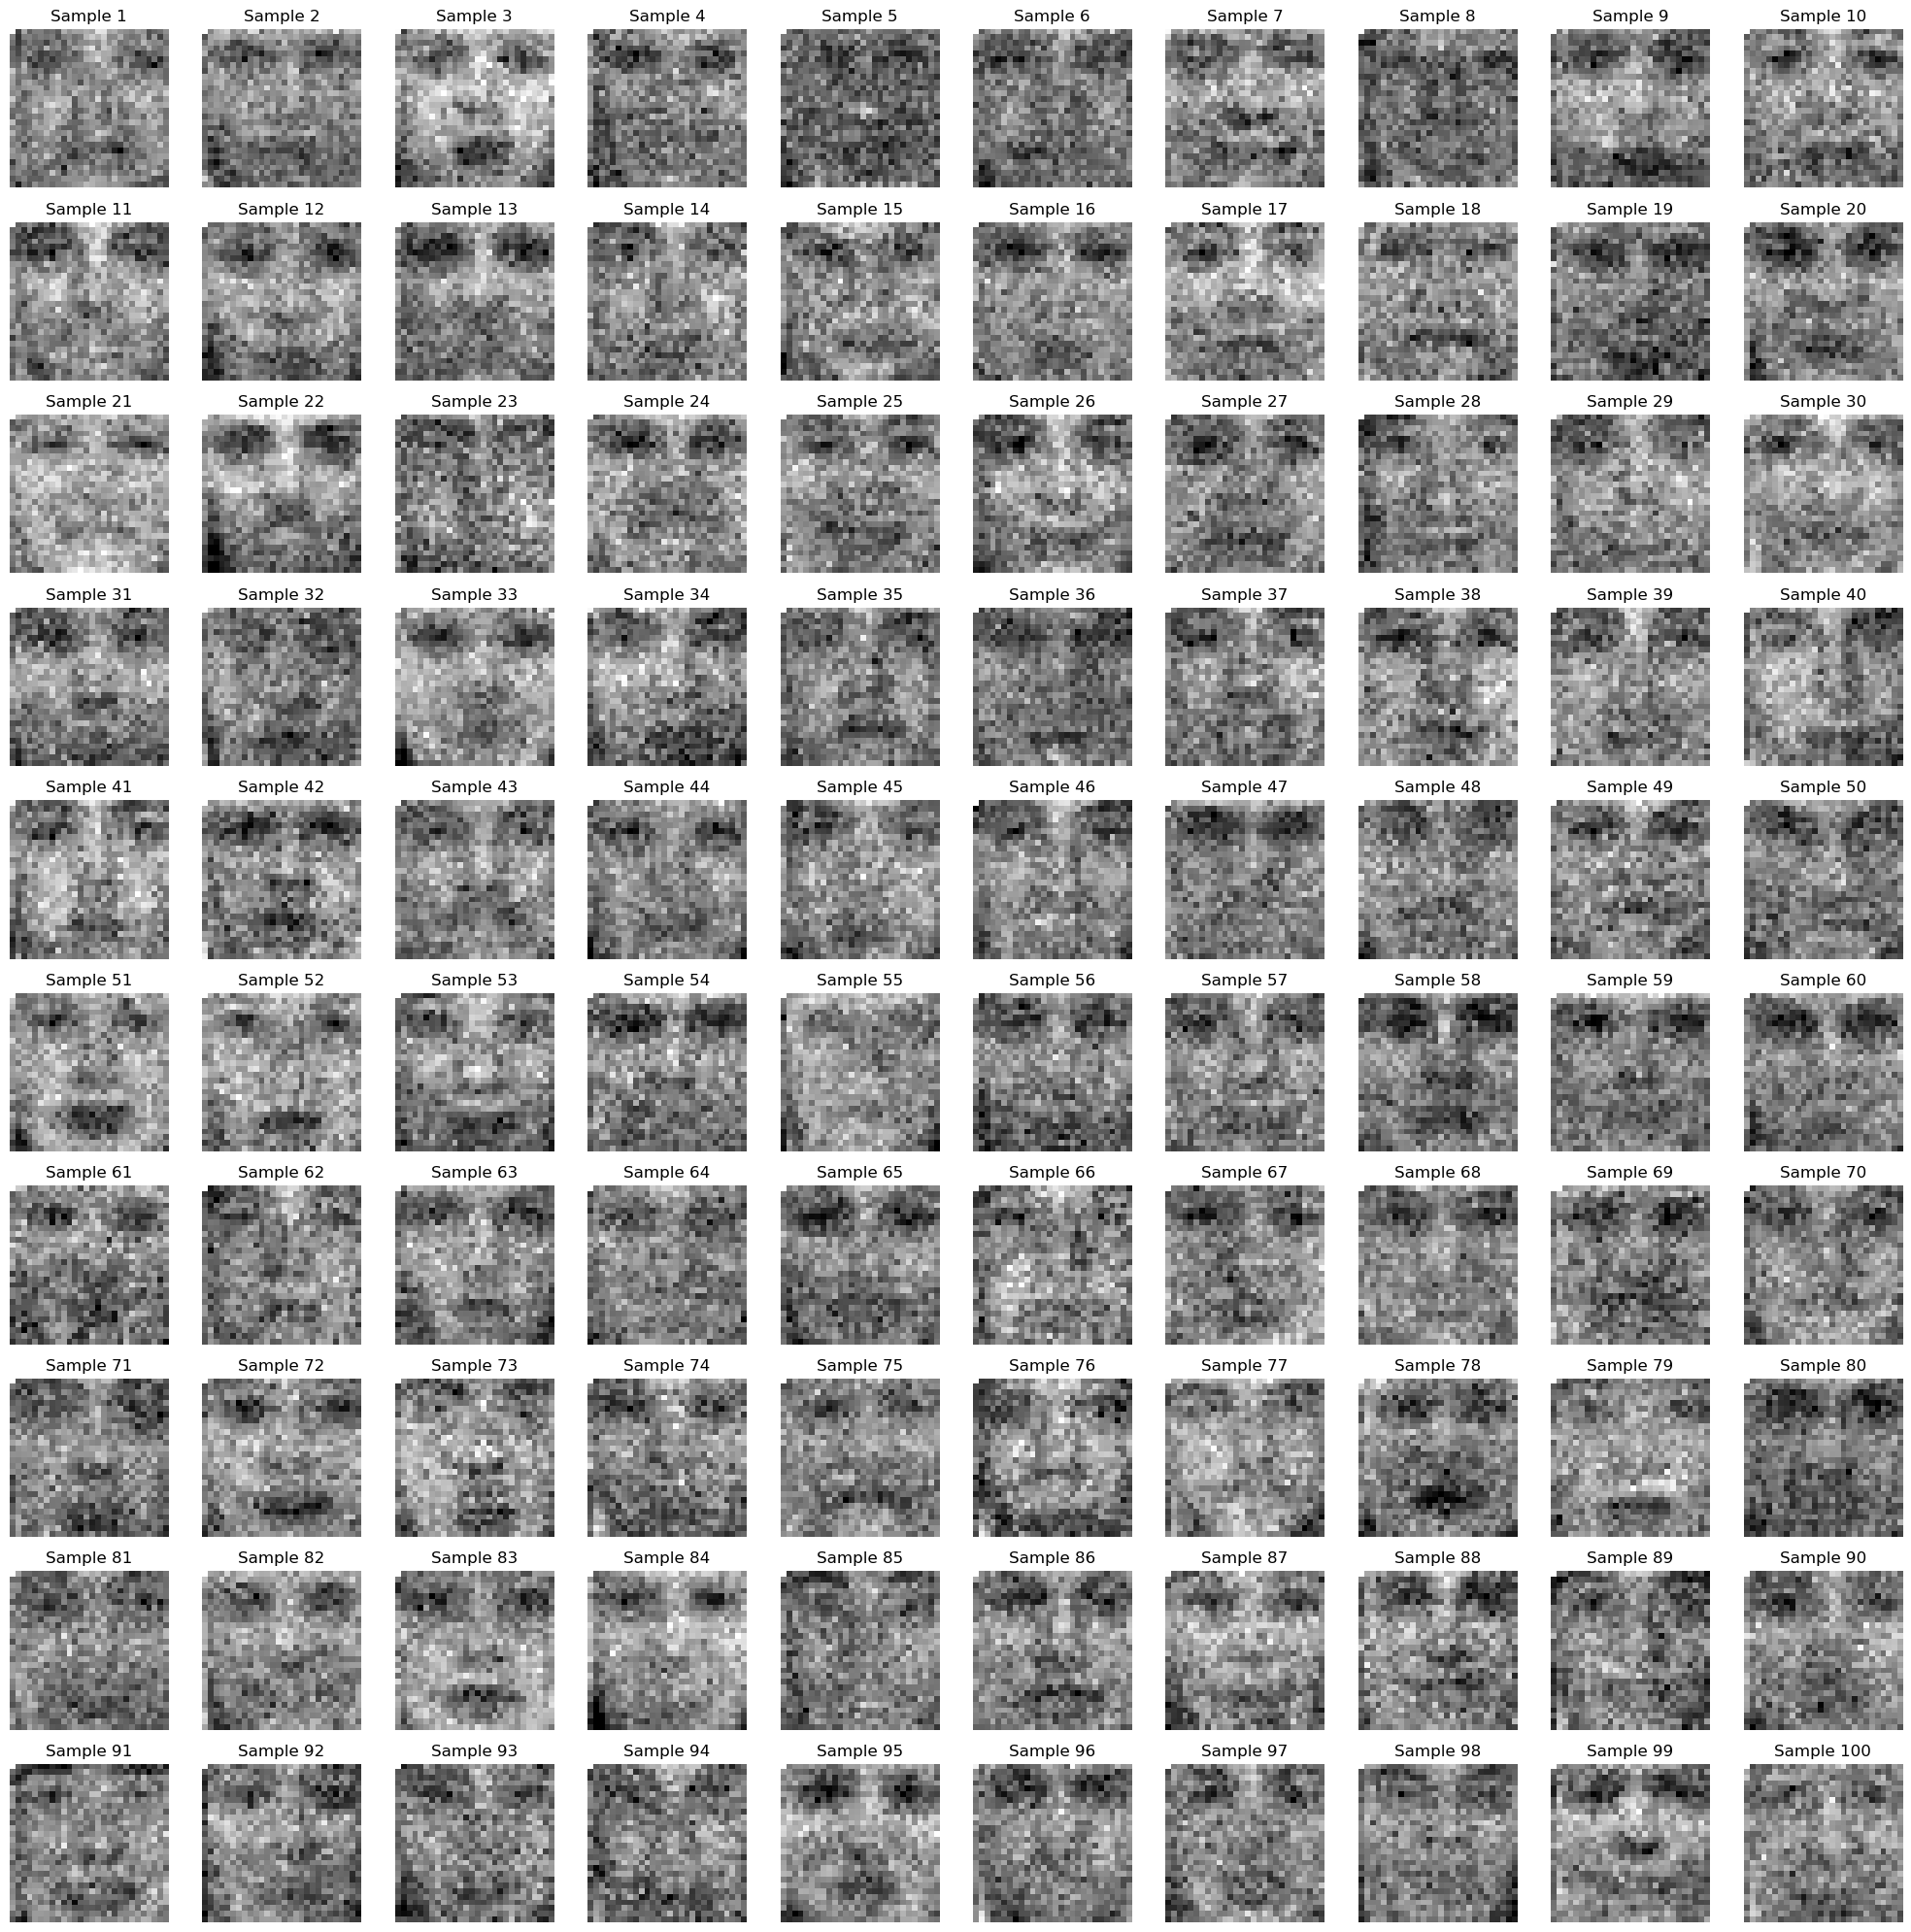

In [8]:
sample_efficient_plot_multiply(model_generic.to(device), t_max=1, n_iter=1, n_samples=100)

It took: 0.16 seconds


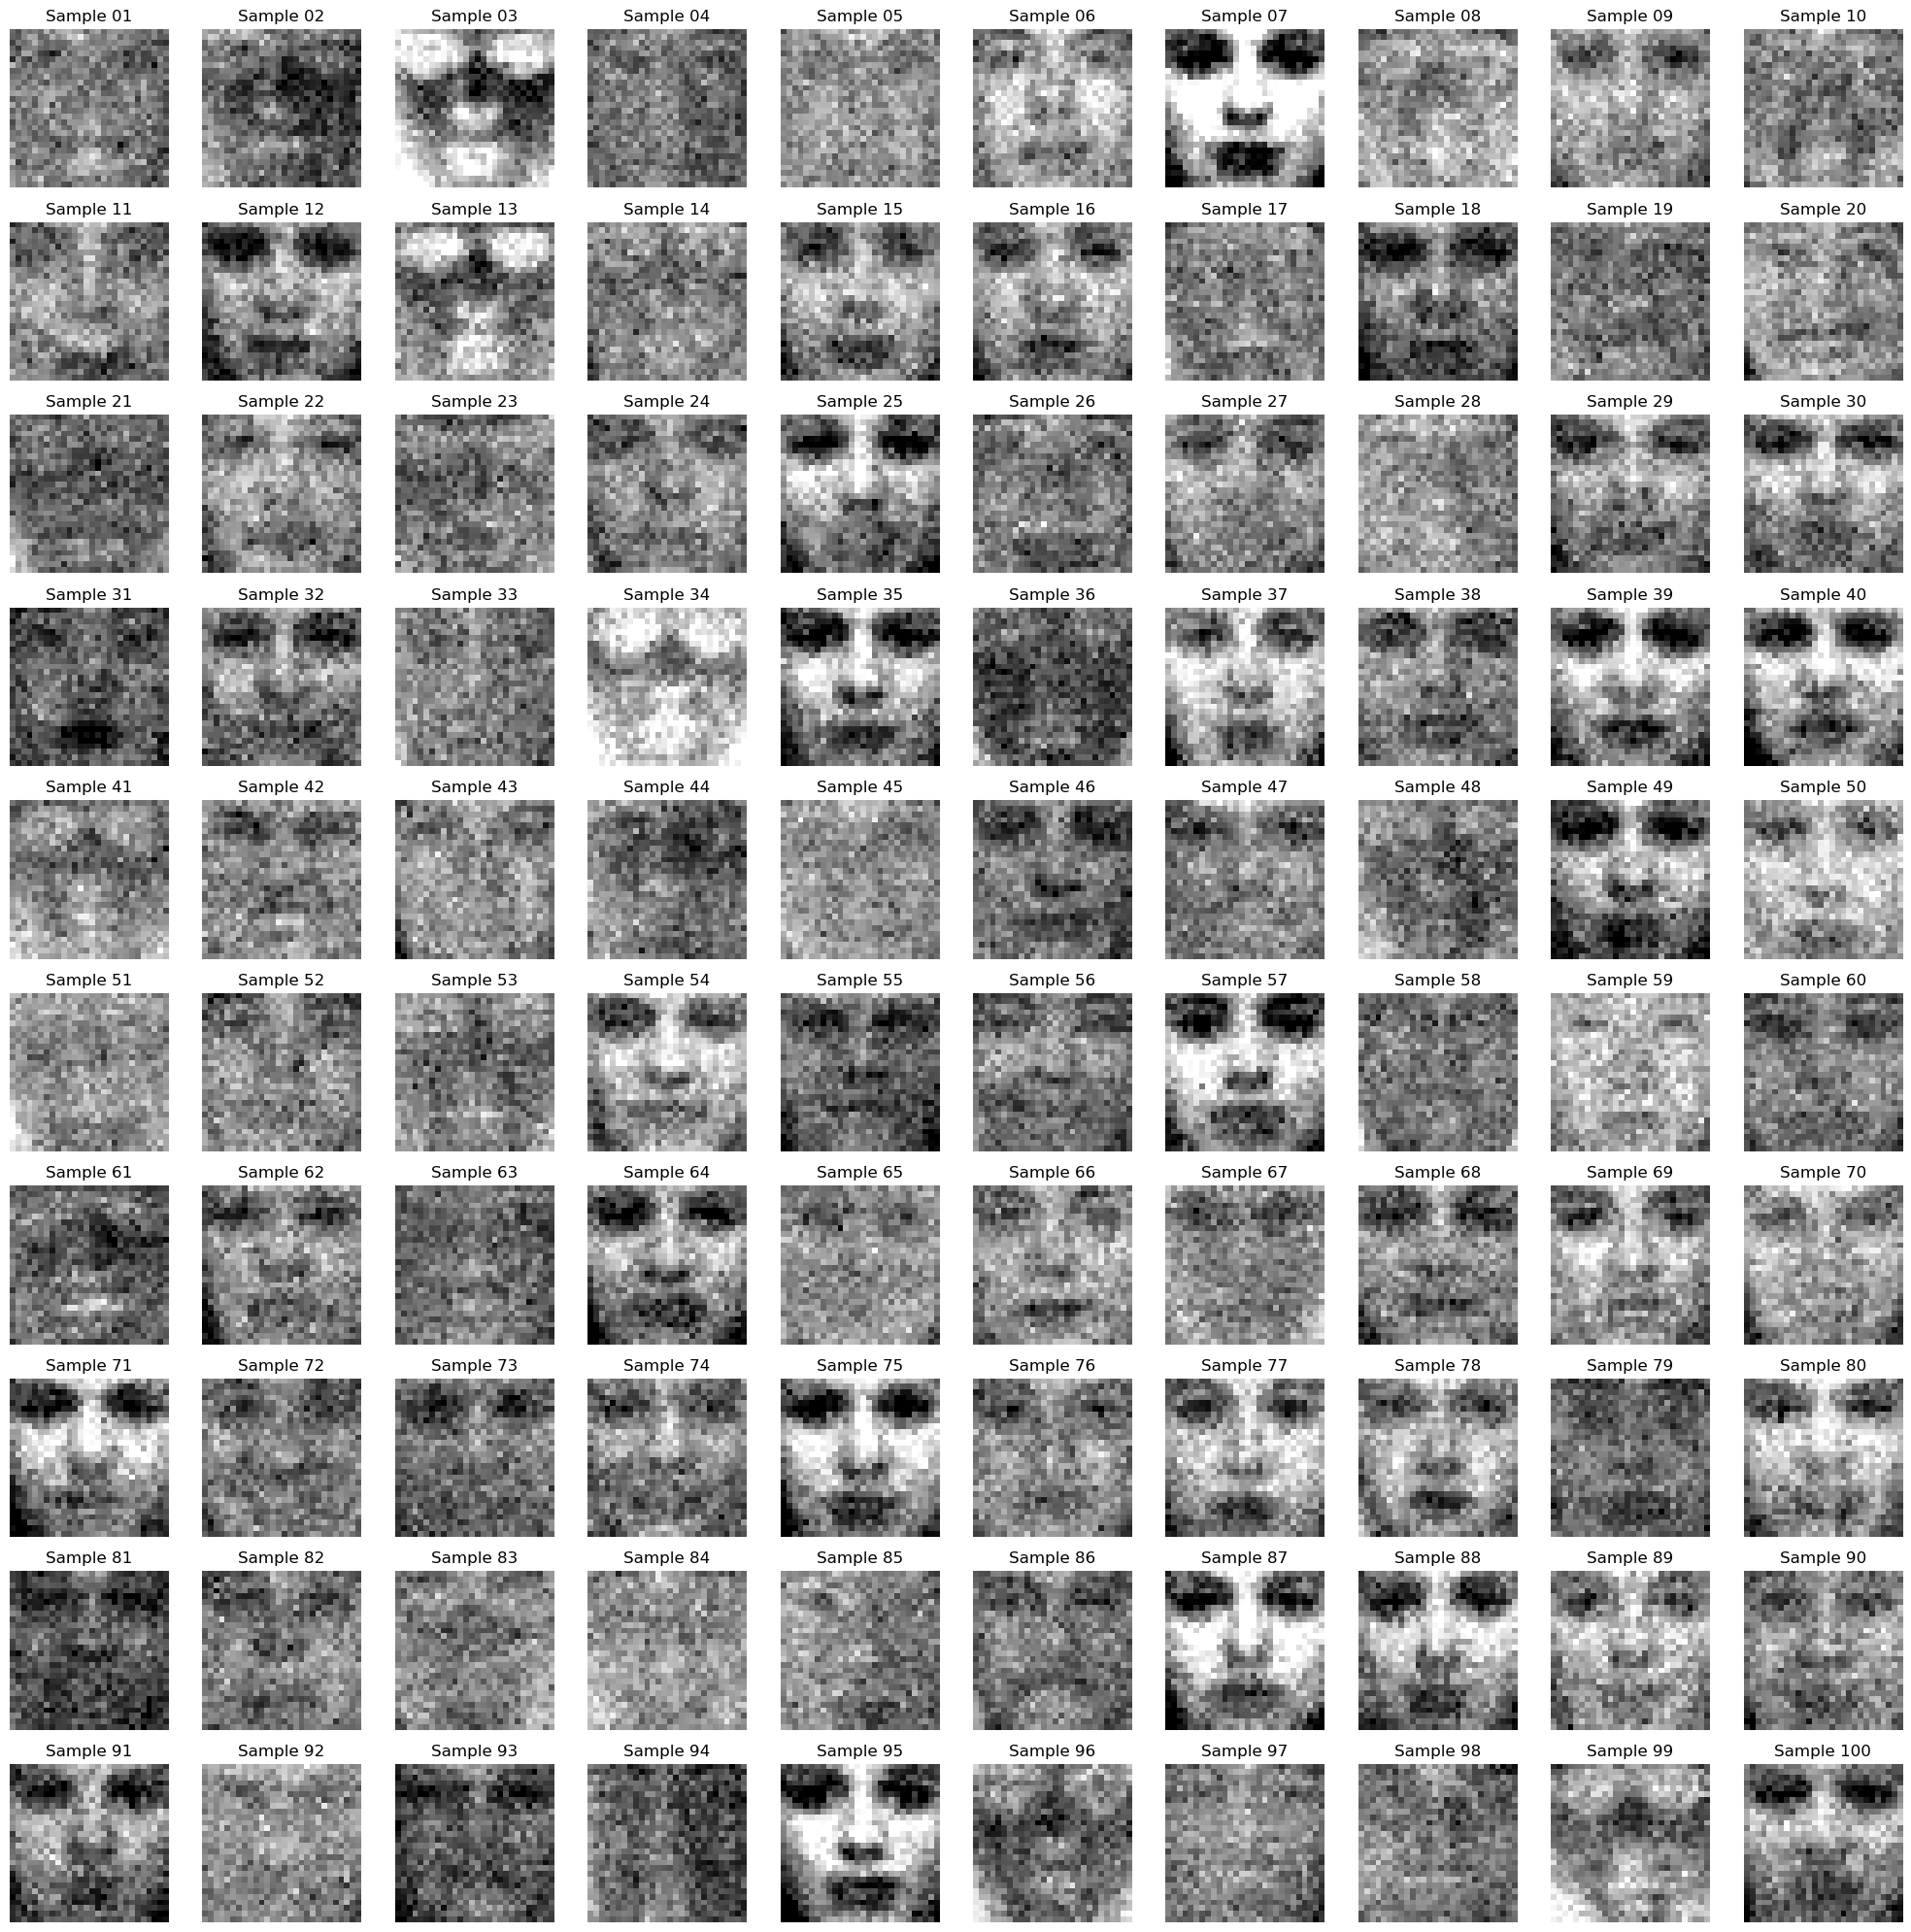

In [9]:

sample_efficient_plot(model_generic.to(device), t_max=1, n_iter=2, n_samples=100)

In [10]:
import numpy as np
import seaborn as sns

# Eigenvectors of Lie

In [11]:
identity = torch.eye(1569).to("cuda")
lie_module = model_generic.to("cuda").koopman(identity).detach().cpu().numpy()
vals, vecs = np.linalg.eig(lie_module)

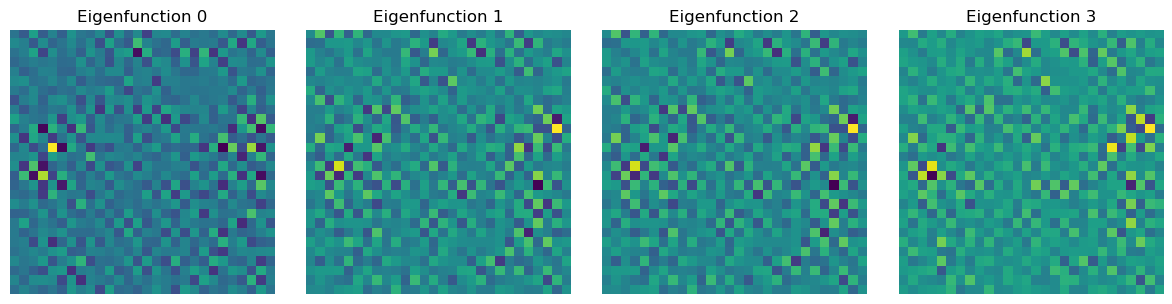

In [12]:
#fifty lowest
import matplotlib.pyplot as plt
import numpy as np


indices = np.argsort(np.real(vals))[:4]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]

def plot_koopman_eigenfunctions(vecs, shape=(28, 28), cols=4, cmap='viridis', normalize=True):
    
    n = vecs.shape[1]
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axs = axs.flatten()

    for i in range(n):
        eigvec = np.real(vecs[1:1+28*28, i])#.real  # or .imag if you want imaginary part
        eigfunc = eigvec.reshape(shape)

        if normalize:
            eigfunc = (eigfunc - eigfunc.min()) / (eigfunc.max() - eigfunc.min() + 1e-8)

        axs[i].imshow(eigfunc, cmap=cmap)
        axs[i].set_title(f"Eigenfunction {i}")
        axs[i].axis("off")

    for i in range(n, len(axs)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)


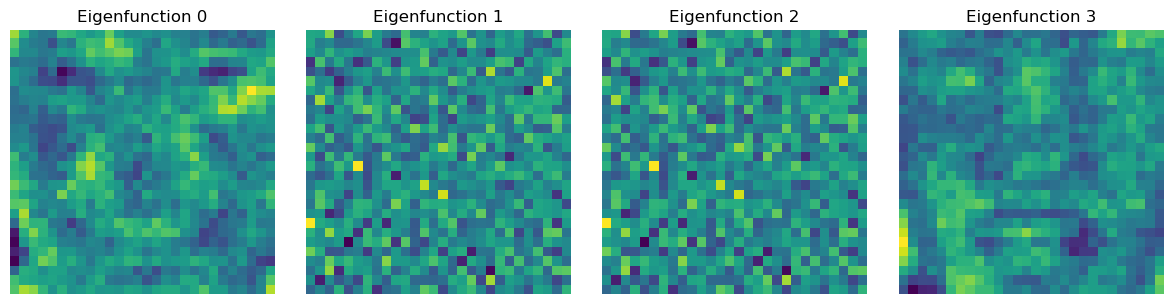

In [13]:
indices = np.argsort(np.real(vals))[750:754]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

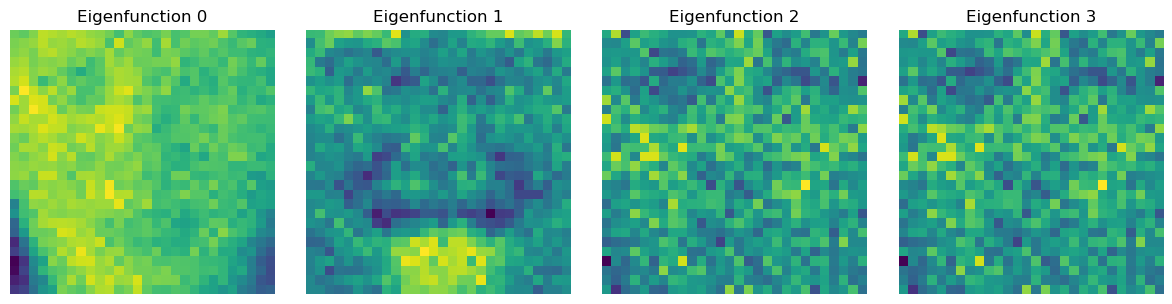

In [14]:
indices = np.argsort(np.real(vals))[-4:]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

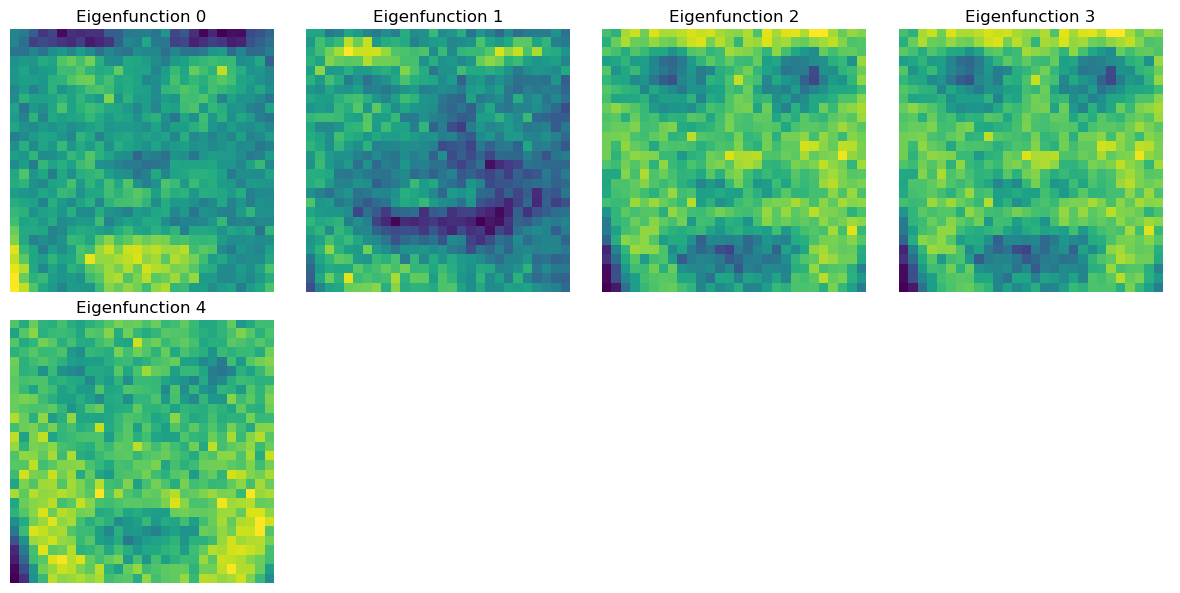

In [15]:
#zero eigenvalues
threshold = 1e-1  # Adjust based on numerical precision
indices = np.where(np.abs(vals) < threshold)[0][:5]
vals_sorted = vals[indices]
vecs_sorted = vecs[:,indices]
plot_koopman_eigenfunctions(vecs_sorted, shape=(28, 28), cols=4)

In [16]:
from time import time

# Analytical Projection with select Modes

In [17]:
#project on a subset of decided indices
def sample_analytical_plot(model_generic, t_max=1, n_samples=1, start=0, end=1568):
    x_0 = torch.randn((n_samples, 28, 28)).to(device)  # Initial conditions
    
    #Get
    identity = torch.eye(1569).to(device)
    lie_module = model_generic.to(device).koopman(identity)
    vals, P = torch.linalg.eig(lie_module)
    indices = torch.argsort(vals.real)
    indices = indices[start:end]
    
    
    
    
    P = P[:,indices]
    P_1 = torch.linalg.pinv(P) 
    vals = vals[indices]
    print(vals.shape)
    print(P_1.shape)
    
    
    
    # Preprocess initial conditions
    t0 = torch.zeros((n_samples, 1), dtype=torch.float32).to(device)
    x_0 = x_0.reshape(n_samples, -1).to(device)

    x_0 = torch.cat((t0, x_0), dim=1)



    #actual sampling time
    top = time()
    encoded = model_generic.autoencoder.encoder(x_0).to(torch.complex64)
    #print(encoded.shape)
    projected = (encoded@P)
    #print(projected.shape)
    evolved = (projected@torch.diag(torch.exp(vals*t_max)))
    #print(evolved.shape)
    decoded = model_generic.autoencoder.decoder((evolved@P_1).real).detach().cpu().numpy()
    

    # Koopman evolution in latent space
    torch.cuda.empty_cache()
    
    
    
    print(f'It took: {time()-top:.2f} seconds')

    # Plot all samples in a grid
    n_cols = math.ceil(math.sqrt(n_samples))
    n_rows = math.ceil(n_samples / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    axs = np.atleast_1d(axs).flatten()

    for i in range(n_samples):
        img = decoded[i][1:1 + 28 * 28].reshape((28, 28)).clip(-1, 1)
        axs[i].imshow(img, cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"Sample {i + 1}")

    for j in range(n_samples, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()
    
    
    #return decoded.reshape((n_samples, 28, 28))

In [18]:
# n_samples = 1
# x_0 = torch.randn((n_samples, 28, 28))  # Initial conditions
# x_0 = x_0.to("cuda").reshape((n_samples, 28 * 28)).to("cuda")

In [19]:
# init = torch.randn(1,28*28).to(("cuda"))

torch.Size([1568])
torch.Size([1568, 1569])
It took: 0.09 seconds


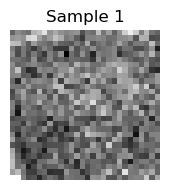

In [20]:
sample_analytical_plot(model_generic,t_max=1, n_samples=1, start=0,end=1568)

torch.Size([100])
torch.Size([100, 1569])
It took: 0.04 seconds


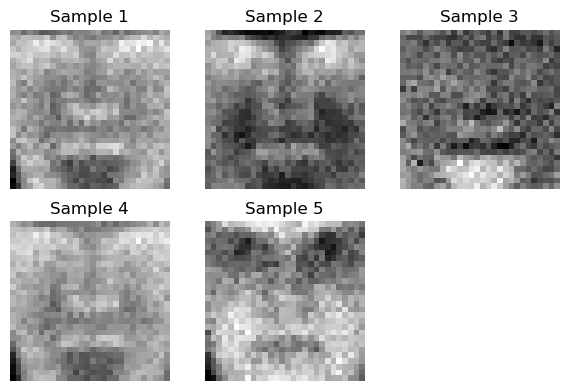

In [21]:
sample_analytical_plot(model_generic, t_max=0.8, n_samples=5, start=1300,end=1400)

torch.Size([69])
torch.Size([69, 1569])
It took: 0.02 seconds


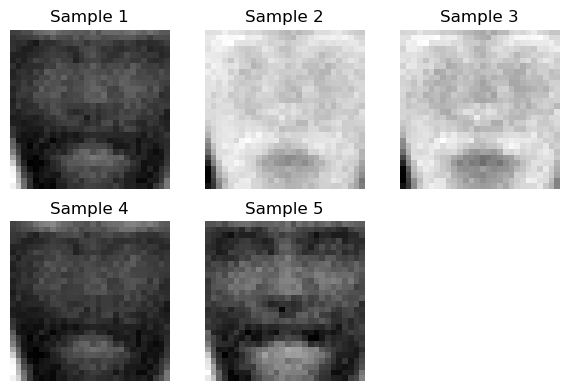

In [22]:
sample_analytical_plot(model_generic, t_max=1, n_samples=5, start=1500,end=1569)

# T-SNE trajectories

In [23]:
def analytical_trajectories(model_generic, traj, n_traj=1, start=0,end=50, device="cpu"):
    model_generic = model_generic.to(device)
    x_0 = traj[0][:n_traj].to(device)  # shape: (n_traj, 1, 28, 28)
    timespan = torch.linspace(0,1, 100).to(device)

    # Koopman operator and eigendecomposition
    L = model_generic.koopman.operator.to(device).to(torch.complex64)
    vals, P = torch.linalg.eig(L)
    indices = torch.argsort(np.real(vals))
    indices = indices[start:end]

    
       
    # Use only selected subset
    indices = torch.tensor(indices, dtype=torch.long, device=device)
    P_k = P[:, indices]
    vals_k = vals[indices]

    P_k_inv = torch.linalg.pinv(P_k)

    trajectories = []

    # Preprocess initial state
    x_0 = x_0.reshape((n_traj, 28 * 28))
    trajectories.append(x_0)

    for t in timespan[:-1]:
        t_tensor = torch.full((n_traj, 1), t, dtype=torch.float32).to(device)
        x = torch.cat((t_tensor, x_0), dim=1)

        encoded = model_generic.autoencoder.encoder(x).to(torch.complex64)

        # Koopman evolution using selected modes
        alpha = encoded @ P_k                      # project to selected Koopman subspace
        evolved = alpha @ torch.diag(torch.exp(vals_k * t))  # time evolution
        z_t = evolved @ P_k_inv                    # project back to latent space

        x = model_generic.autoencoder.decoder(z_t.real)
        x_0 = x[:, 1:]  # remove time channel

        trajectories.append(x_0)

    return torch.stack(trajectories, dim=0)  


# T-SNE trajectories of Koopy vs CFM

/tmp/ipykernel_1040814/3210286581.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x800 with 0 Axes>

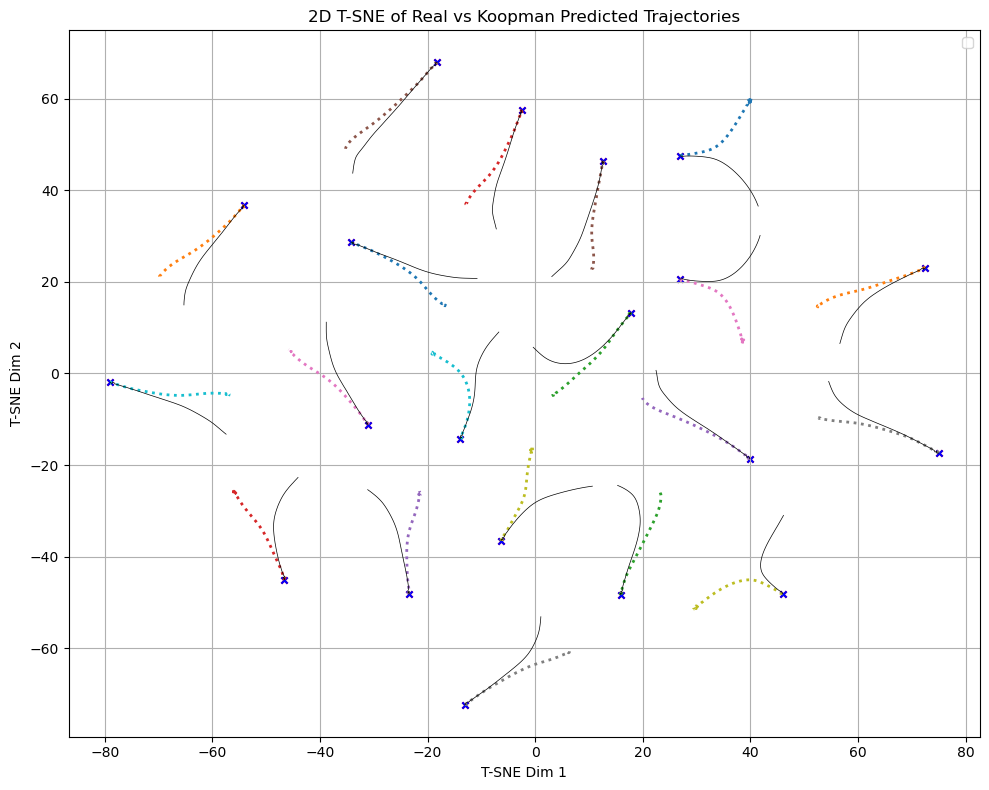

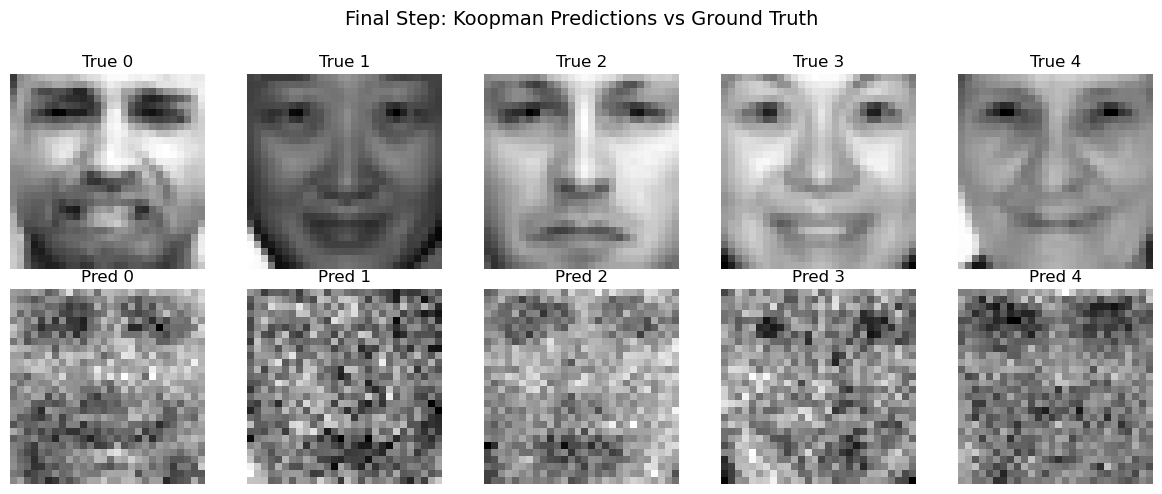

In [24]:
def analytical_trajectories(model_generic , traj, n_traj=1, device="cpu"):
    model_generic = model_generic.to(device)
    x_0 = traj[0][:n_traj].to(device)  # Initial conditions
    #x_0 = torch.randn_like(x_0).to(device)
    timespan = torch.linspace(0,1,100).to(device)
    

    lie_module = model_generic.koopman.operator.to(device)
    delta_t = timespan[1]-timespan[0]
    koopman = torch.matrix_exp(lie_module*delta_t)
    
    trajectories = []
    
    
    # Preprocess initial conditions
    
    x_0 = x_0.reshape((n_traj, 28 * 28))
    trajectories.append(x_0)
    for t in timespan[:-1]:
        
        if t==0:
            t_tensor = torch.ones((n_traj, 1), dtype=torch.float32).to(device)*t
        else:
            t_tensor = x[:,0].reshape(-1,1)
        x = torch.cat((t_tensor, x_0), dim=1)
        encoded = model_generic.autoencoder.encoder(x)
        evolved = encoded@koopman
        x = model_generic.autoencoder.decoder(evolved)
        x_0 = x[:,1:]

        trajectories.append(x_0)   
    

    
    
    
    return torch.stack(trajectories, dim=0)

koopman_trajectories = analytical_trajectories(model_generic , traj=traj, n_traj=20)
koopman_trajectories.shape
traj_flattened = traj[:,:20,:,:].reshape(koopman_trajectories.shape)
traj_flattened.shape

from sklearn.manifold import TSNE

# Convert to NumPy
koopman_trajectories_np = koopman_trajectories.detach().numpy()  # (100, 20, 784)
koopman_samples = koopman_trajectories_np[-1,:,:].reshape(20,28,28)

traj_flattened_np = traj_flattened.detach().numpy()              # Possibly (100, 20, 784)
true_samples = traj_flattened_np[-1,:,:].reshape(20, 28, 28)

# Fix shape
traj_data = traj_flattened_np.reshape(-1, 784)        # Now (100, 784)

# Flatten koopman trajectories: (5, 100, 784) -> (500, 784)
koopman_data = koopman_trajectories_np.reshape(-1, 784)

# Combine for TSNE
combined = np.concatenate([traj_data, koopman_data], axis=0)

# Apply TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined)

# Split results back
real_tsne = tsne_results[:traj_data.shape[0]].reshape(100, 20, 2)
koopman_tsne = tsne_results[traj_data.shape[0]:].reshape(100, 20, 2)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for i in range(20):
    # Koopman predicted trajectory
    plt.plot(koopman_tsne[:, i, 0], koopman_tsne[:, i, 1], linestyle="dotted", linewidth=2, alpha=1)
    plt.scatter(koopman_tsne[0, i, 0], koopman_tsne[0, i, 1], color='red', marker='x', s=20)

    # Real trajectory
    plt.plot(real_tsne[:, i, 0], real_tsne[:, i, 1], color='black', linewidth=0.5)
    plt.scatter(real_tsne[0, i, 0], real_tsne[0, i, 1], color='blue', marker='x', s=20)

plt.title("2D T-SNE of Real vs Koopman Predicted Trajectories")
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Koopman vs True samples at final time step
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Final Step: Koopman Predictions vs Ground Truth", fontsize=14)

# Top row: Ground truth
for i in range(5):
    axes[0, i].imshow(true_samples[i], cmap="gray")
    axes[0, i].set_title(f"True {i}")
    axes[0, i].axis("off")

# Bottom row: Koopman predictions
for i in range(5):
    axes[1, i].imshow(koopman_samples[i], cmap="gray")
    axes[1, i].set_title(f"Pred {i}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def run_koopman_tsne_plot(model_generic, traj, n_traj=20, device="cpu"):
    def analytical_trajectories(model_generic, traj, n_traj=1, device="cpu"):
        model_generic = model_generic.to(device)

        #initial conditions
        x_0 = traj[0][:n_traj].to(device)
        timespan = torch.linspace(0, 1, 100).to(device)

        lie_module = model_generic.koopman.operator.to(device)
        delta_t = timespan[1] - timespan[0]
        koopman = torch.matrix_exp(lie_module * delta_t)

        trajectories = []
        x_0 = x_0.reshape((n_traj, 28 * 28))
        trajectories.append(x_0)

        for t in timespan[:-1]:
            t_tensor = torch.full((n_traj, 1), t, dtype=torch.float32).to(device)
            x = torch.cat((t_tensor, x_0), dim=1)
            encoded = model_generic.autoencoder.encoder(x)
            evolved = encoded @ koopman
            x = model_generic.autoencoder.decoder(evolved)
            x_0 = x[:, 1:]
            trajectories.append(x_0)

        return torch.stack(trajectories, dim=0)  # (time, batch, 784)

    #Simulate Koopman Trajectories
    koopman_trajectories = analytical_trajectories(model_generic, traj, n_traj=n_traj, device=device)
    traj_flattened = traj[:koopman_trajectories.shape[0], :n_traj].reshape(koopman_trajectories.shape)

    #Prepare for t-SNE
    koop_np = koopman_trajectories.detach().cpu().numpy()
    traj_np = traj_flattened.detach().cpu().numpy()

    koop_samples = koop_np[-1].reshape(n_traj, 28, 28)
    true_samples = traj_np[-1].reshape(n_traj, 28, 28)

    traj_data = traj_np.reshape(-1, 784)
    koop_data = koop_np.reshape(-1, 784)

    combined = np.concatenate([traj_data, koop_data], axis=0)
    tsne_results = TSNE(n_components=2, random_state=42).fit_transform(combined)

    real_tsne = tsne_results[:traj_data.shape[0]].reshape(100, n_traj, 2)
    koop_tsne = tsne_results[traj_data.shape[0]:].reshape(100, n_traj, 2)

    #Plot t-SNE Trajectories
    plt.figure(figsize=(10, 8))
    for i in range(n_traj):
        plt.plot(koop_tsne[:, i, 0], koop_tsne[:, i, 1], linestyle="dotted", linewidth=2, alpha=1)
        plt.scatter(koop_tsne[0, i, 0], koop_tsne[0, i, 1], color='red', marker='x', s=20)
        plt.plot(real_tsne[:, i, 0], real_tsne[:, i, 1], color='black', linewidth=0.5)
        plt.scatter(real_tsne[0, i, 0], real_tsne[0, i, 1], color='blue', marker='x', s=20)

    plt.title("2D T-SNE of Real vs Koopman Predicted Trajectories")
    plt.xlabel("T-SNE Dim 1")
    plt.ylabel("T-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Plot Final Step: Koopman vs Ground Truth ===
    fig, axes = plt.subplots(2, min(n_traj, 5), figsize=(12, 5))
    fig.suptitle("Final Step: Koopman Predictions vs Ground Truth", fontsize=14)

    for i in range(min(n_traj, 5)):
        axes[0, i].imshow(true_samples[i], cmap="gray")
        axes[0, i].set_title(f"True {i}")
        axes[0, i].axis("off")

        axes[1, i].imshow(koop_samples[i], cmap="gray")
        axes[1, i].set_title(f"Pred {i}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


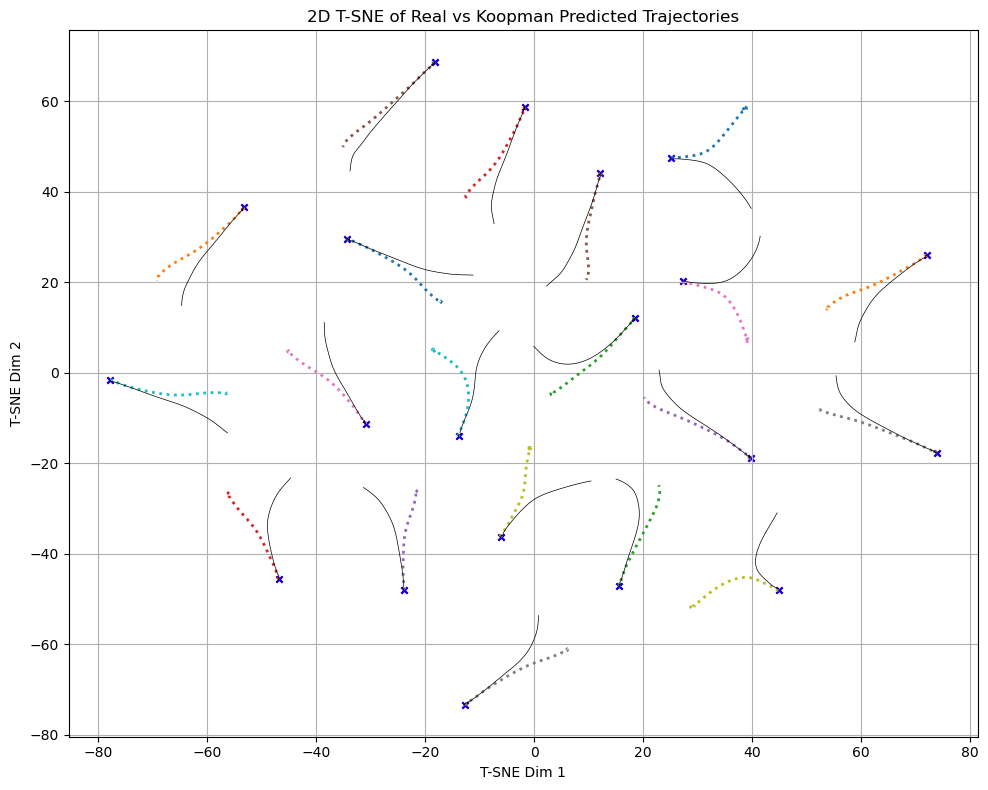

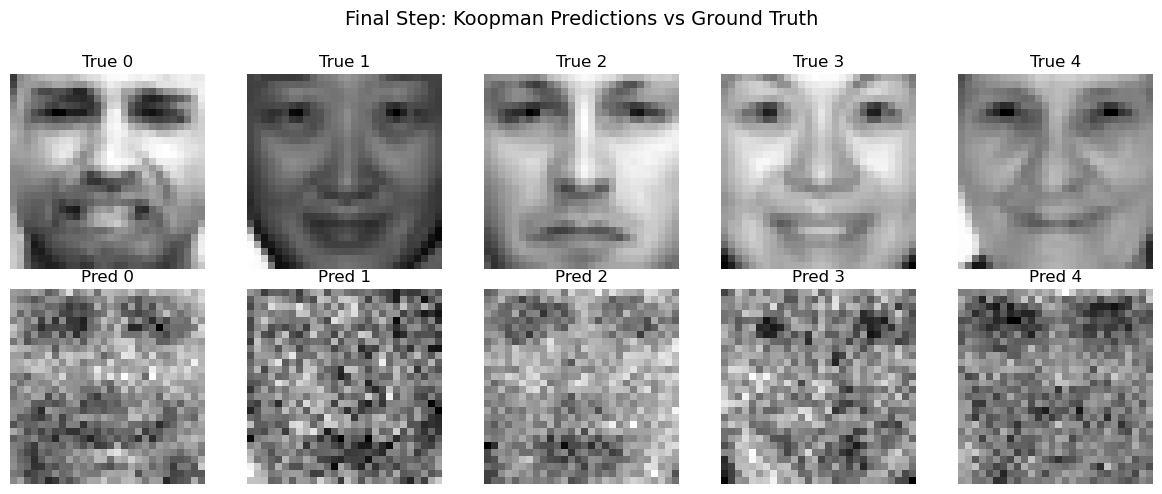

In [26]:
run_koopman_tsne_plot(model_generic, traj, n_traj=20, device="cpu")


# Non-Linear measurements discerning? 

In [27]:
# Model to classify the what trajectory leads to
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate model, optimizer, loss
classifier = SimpleCNN().to(device)
classifier.load_state_dict(torch.load("best_mnist_classifier.pt"))

/tmp/ipykernel_1040814/2370074199.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load("best_mnist_classifier.pt"))


FileNotFoundError: [Errno 2] No such file or directory: 'best_mnist_classifier.pt'

In [ ]:
#script to train it
classifier = SimpleCNN().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Optional validation loader
val_loader = test_loader

# Training loop
best_acc = 0.0
for epoch in range(1, 11):  # 10 epochs
    classifier.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(classifier(images), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Train Loss: {total_loss / len(train_loader):.4f}")

    # Evaluate on validation set
    classifier.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    print(f"Validation Accuracy: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(classifier.state_dict(), "best_mnist_classifier.pt")

NameError: name 'optim' is not defined

In [28]:
#Get the labels for a trajectory
def trajectory_labels(traj, classifier, batch_size, device="cpu"):
    generated = traj[-1,:,:,:,:]
    labels = []
    classifier = classifier.to(device)
    for i in range(0,traj.shape[1],batch_size):
        start = i
        end = start+batch_size
        batch = generated[start:end].to(device)
        outputs = classifier(batch)
        preds = outputs.argmax(1)
        labels.append(preds)
    return torch.cat(labels)

labels = trajectory_labels(traj, classifier, 128)

In [29]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.manifold import TSNE
import torch
import numpy as np

def tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000, time_step=0, 
                              modes_to_use=None, device="cpu"):
    model_generic = model_generic.to(device)
    
    # Time setup
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]
    t = time_step * delta_t
    
    # Prepare input
    x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
    t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
    x_t = torch.cat((t_0, x_0), dim=1)

    # Encode to latent space
    encoded = model_generic.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)

    # Koopman eigendecomposition
    koopman_op = model_generic.koopman.operator.to(device).to(torch.complex64)
    vals, P = torch.linalg.eig(koopman_op)  # P: (D, D)
    order = torch.argsort(np.real(vals))
    vals, P = vals[order], P[:,order]

    # Select Koopman modes (columns of P)
    if modes_to_use is None:
        modes_to_use = torch.arange(P.shape[1])  # use all modes if none selected
    P_subset = P[:, modes_to_use]  # (D, len(modes_to_use))

    # Project onto selected Koopman modes
    alpha = encoded @ P_subset  # (n_samples, len(modes_to_use))

    # t-SNE on projected Koopman coordinates
    alpha_real = alpha.real.detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(alpha_real)

    # Labels
    labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

    # Plot using tab10
    cmap = get_cmap('tab10')
    plt.figure(figsize=(8, 6))
    for i in range(10):
        idx = labels_np == i
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1],
                    c=[cmap(i)], label=f"Class {i}", s=6, alpha=0.8)
    
    plt.legend(markerscale=2, fontsize=9, title="Classes")
    plt.title("t-SNE on Subset of Koopman Modes")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1040814/2424208637.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


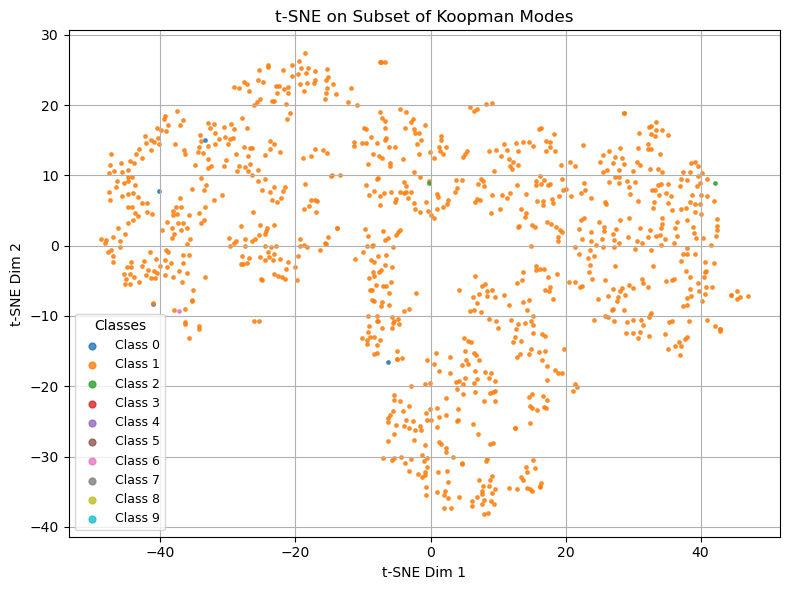

In [30]:
tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000, time_step=99, 
                              modes_to_use=[i for i in range(1500,1568)], device="cpu")

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def k_nn_accuracy_over_time(model, traj, labels, modes_to_use, n_samples, device="cpu"):
    accuracies = []
    time_steps = np.linspace(0, 99, 10, dtype=int)  # 10 step increments from t=0 to t=1
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]
    model = model.to(device)

    for time_step in time_steps:
        t = time_step * delta_t

        # Prepare input
        x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
        t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
        x_t = torch.cat((t_0, x_0), dim=1)

        # Encode to latent space
        encoded = model.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)

        # Koopman eigendecomposition
        koopman_op = model.koopman.operator.to(device).to(torch.complex64)
        vals, P = torch.linalg.eig(koopman_op)
        order = torch.argsort(torch.real(vals))
        vals, P = vals[order], P[:, order]

        # Select Koopman modes
        if modes_to_use is None:
            modes_to_use = torch.arange(P.shape[1])
        P_subset = P[:, modes_to_use]

        # Project onto selected Koopman modes
        alpha = encoded @ P_subset
        alpha_real = alpha.real.detach().cpu().numpy()

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(alpha_real)

        # K-NN classification
        labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]
        X_train, X_test, y_train, y_test = train_test_split(tsne_result, labels_np, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot
    times = time_steps * delta_t.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(times, accuracies, marker='o')
    plt.title("K-NN Classification Accuracy over Time")
    plt.xlabel("Time t")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return accuracies


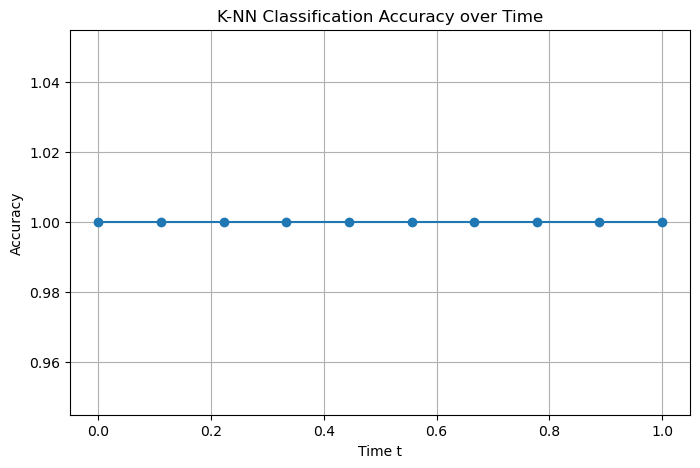

In [32]:
#for fast decay 0-200 modes 
accuracies_decay = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(50)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

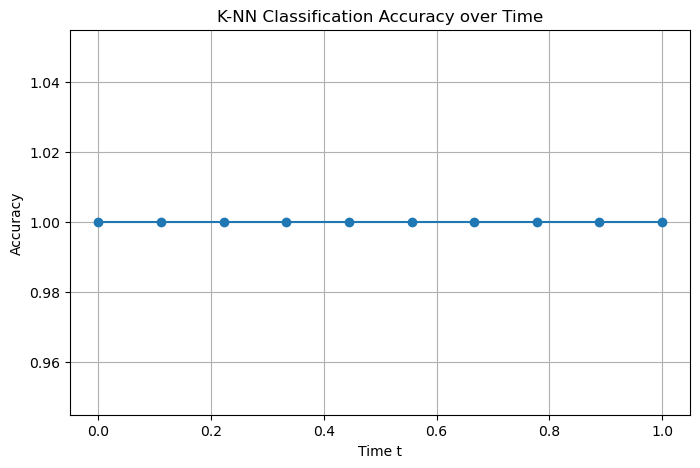

In [33]:
#for middle modes
accuracies_mid = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(600,800)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

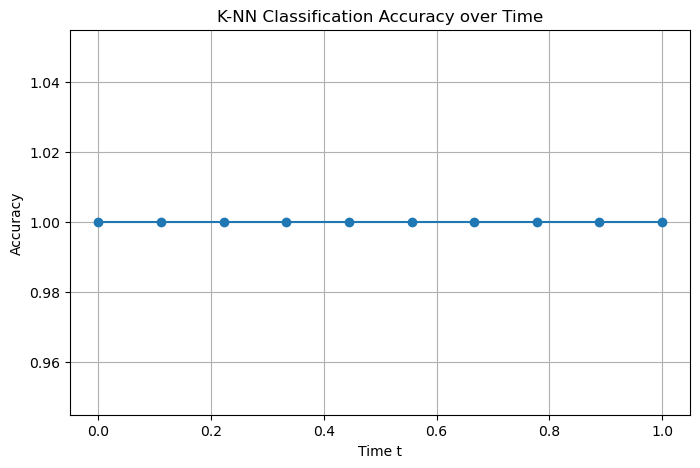

In [34]:
#for fast growth
accuracies_growth = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(1500,1569)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

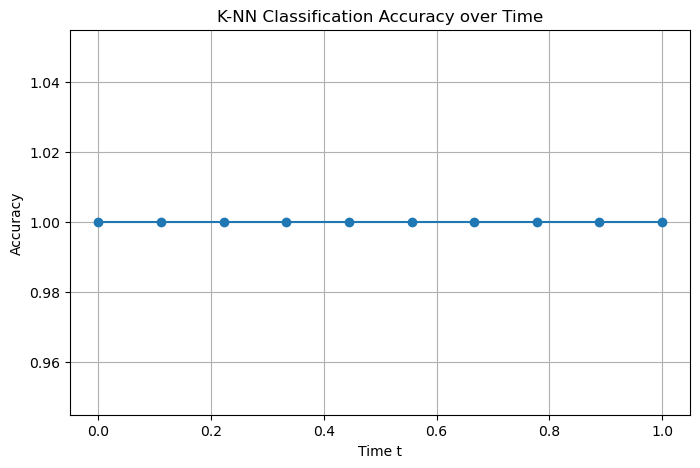

In [35]:
#all modes
accuracies = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(0,1568)],
    n_samples=200,
    device="cpu"  # or "cpu"
)

In [36]:
len(accuracies_decay)

10

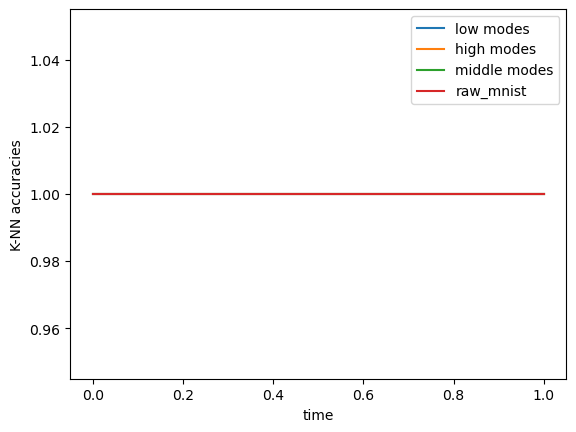

In [37]:
t = np.linspace(0,1,10)
plt.plot(t, accuracies_decay, label="low modes")
plt.plot(t, accuracies_growth, label="high modes")
plt.plot(t, accuracies_mid, label="middle modes")
plt.plot(t, accuracies, label="raw_mnist")
plt.xlabel("time")
plt.ylabel("K-NN accuracies")
plt.legend()


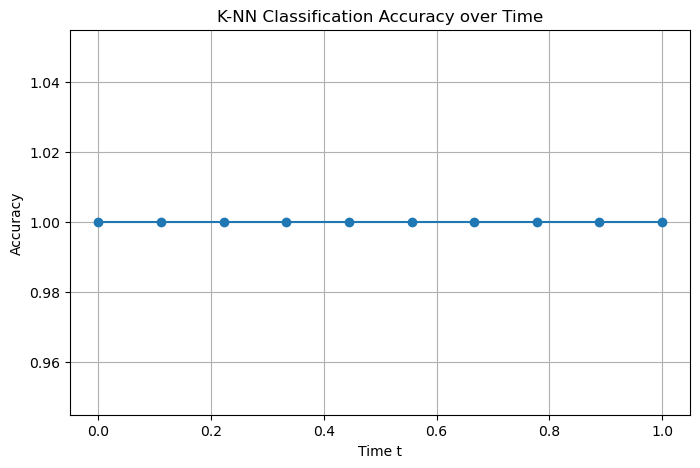

In [38]:
#for fast decay 400-600 modes
accuracies = k_nn_accuracy_over_time(
    model=model_generic,
    traj=traj,
    labels=labels,
    modes_to_use=[i for i in range(400,600)],
    n_samples=200,
    device="cpu"  
)

/tmp/ipykernel_1040814/2424208637.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


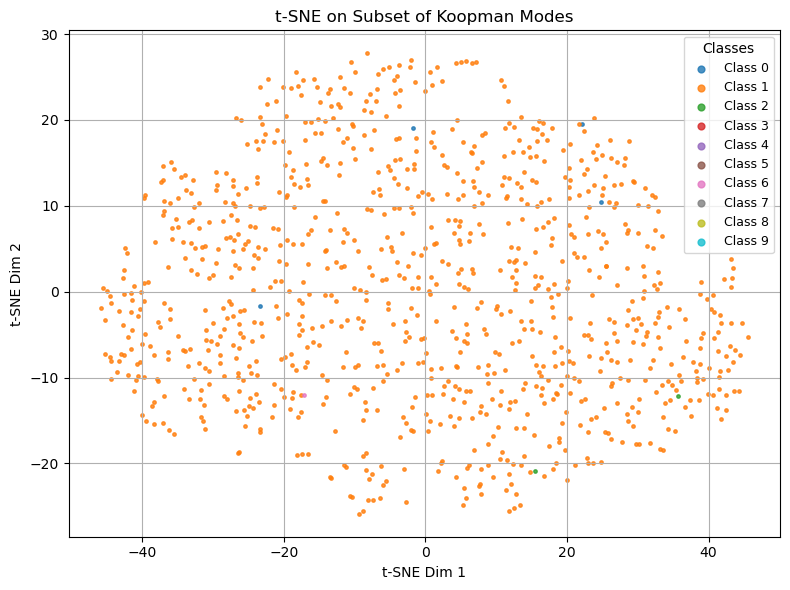

In [39]:
tsne_koopman_subset_modes(model_generic, traj, labels, n_samples=1000,modes_to_use=[i for i in range(1500,1568)], time_step=0)

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_accuracy_raw_mnist(traj, labels, n_samples=1000, device="cpu"):
    accuracies = []
    time_steps = np.linspace(0, 99, 10, dtype=int)  # 10 time steps
    time = torch.linspace(0, 1, 100).to(device)
    delta_t = time[1] - time[0]

    for time_step in time_steps:
        # Get raw MNIST data at this time step
        x = traj[time_step][:n_samples].reshape(n_samples, -1).cpu().numpy()
        y = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        tsne_result = tsne.fit_transform(x)

        # K-NN classification
        X_train, X_test, y_train, y_test = train_test_split(tsne_result, y, test_size=0.2, random_state=42)
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Plot
    times = time_steps * delta_t.cpu().numpy()
    plt.figure(figsize=(8, 5))
    plt.plot(times, accuracies, marker='o')
    plt.title("K-NN Classification Accuracy on Raw MNIST (t-SNE) Over Time")
    plt.xlabel("Time t")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracies


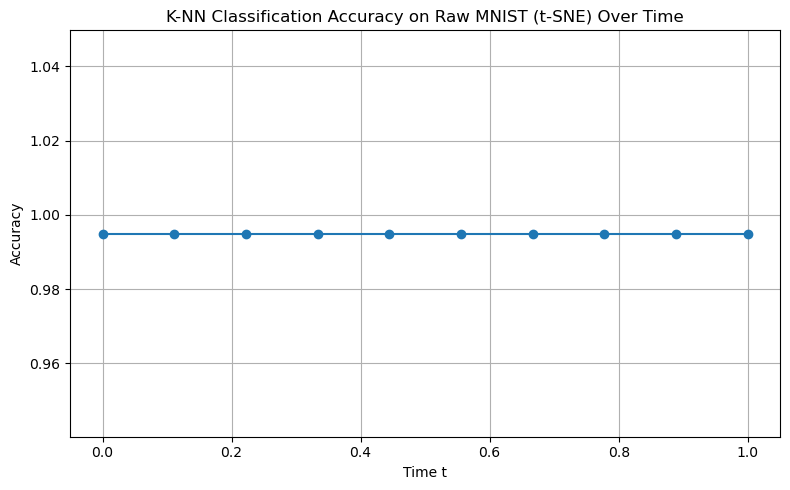

In [41]:
accuracies = knn_accuracy_raw_mnist(traj, labels, n_samples=1000, device="cuda")


In [42]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def tsne_raw_data(model_generic, n_samples=1000,time_step=0, device="cuda"):
    
    


    # t-SNE on Koopman coordinates
    alpha_real = traj[time_step][:n_samples].reshape(n_samples,-1)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(alpha_real)

    # Labels
    labels_np = labels[:n_samples].cpu().numpy() if torch.is_tensor(labels) else labels[:n_samples]

    # Use tab10 colormap
    cmap = get_cmap('tab10')

    plt.figure(figsize=(8, 6))
    for i in range(10):
        idx = labels_np == i
        plt.scatter(
            tsne_result[idx, 0], tsne_result[idx, 1],
            c=[cmap(i)], label=f"Class {i}", s=6, alpha=0.8
        )

    plt.legend(markerscale=2, fontsize=9, title="Classes")
    plt.title("t-SNE of Encoded Inputs in Koopman Eigenbasis")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_1040814/3177795909.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


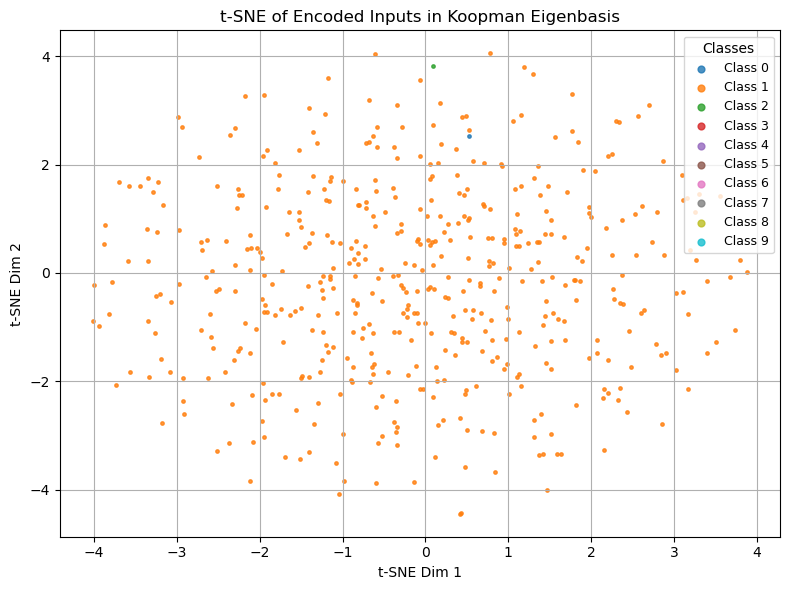

In [43]:
tsne_raw_data(model_generic, n_samples=500,time_step=0, device="cpu")

# Do the n most active modes seperate the classes:

In [44]:
device = "cpu"

/tmp/ipykernel_1040814/4157476675.py:44: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


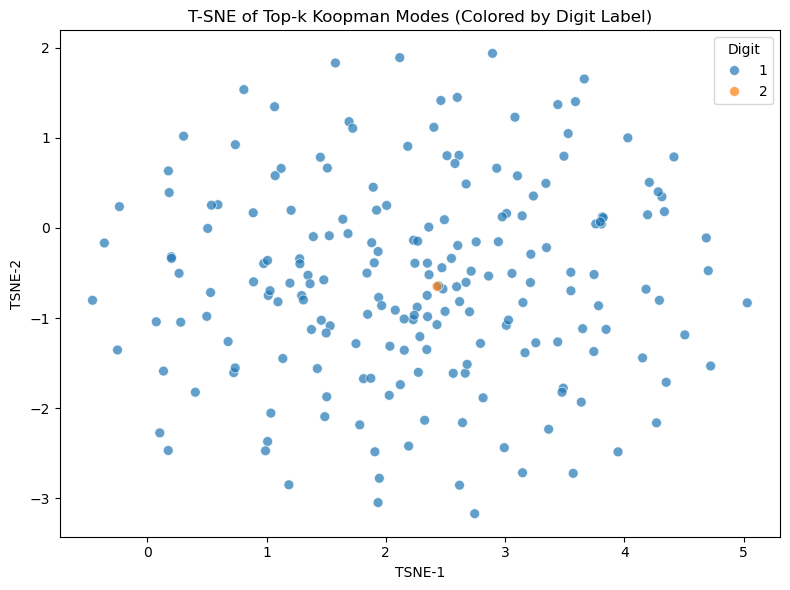

In [45]:
model_generic = model_generic.to(device)
time_step = 99
n_samples = 200   
# Time setup
time = torch.linspace(0, 1, 100).to(device)
delta_t = time[1] - time[0]
t = time_step * delta_t
    
# Prepare input
x_0 = traj[time_step][:n_samples].reshape(n_samples, -1).to(device)
t_0 = torch.full((n_samples, 1), t, dtype=torch.float32).to(device)
x_t = torch.cat((t_0, x_0), dim=1)

# Encode to latent space
encoded = model_generic.autoencoder.encoder(x_t).to(torch.complex64)  # (n_samples, D)
koopman_op = model_generic.koopman.operator.to(device).to(torch.complex64)
vals, P = torch.linalg.eig(koopman_op)
coefficients = encoded@koopman_op 
magnitudes = torch.abs(coefficients)  # shape (4, 10), real-valued
k = 200
topk_values, topk_indices = torch.topk(magnitudes, k=k, dim=1)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns  # for nicer coloring
import numpy as np


topk_indices_np = topk_indices.cpu().numpy()  

labels_np = labels.cpu().numpy()[:n_samples]             

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories='auto')



tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(topk_indices_np)


plt.figure(figsize=(8, 6))
palette = sns.color_palette("tab10", 10)  
sns.scatterplot(
    x=tsne_result[:, 0], y=tsne_result[:, 1],
    hue=labels_np,
    palette=palette,
    legend='full',
    s=50,
    alpha=0.7
)
plt.title("T-SNE of Top-k Koopman Modes (Colored by Digit Label)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend(title="Digit")
plt.tight_layout()
plt.show()


In [46]:
topk_indices_np

array([[  0, 163, 162, ..., 683, 573, 442],
       [759, 731,   0, ..., 658, 614, 746],
       [  0, 190, 175, ..., 142, 699,  31],
       ...,
       [  0, 136, 135, ..., 552, 579, 635],
       [222, 223, 221, ..., 419, 707, 554],
       [  0, 162, 134, ..., 349, 351, 565]])

# Operator + Spectrum

<Axes: >

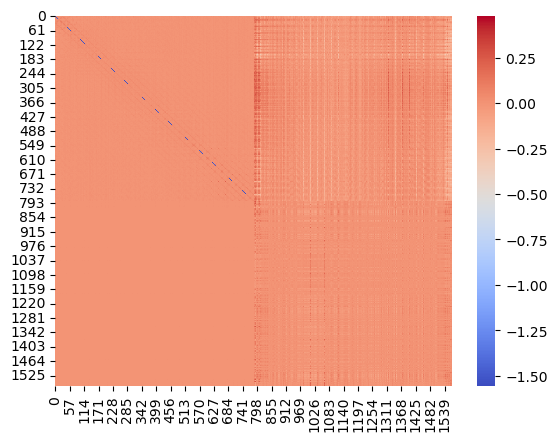

In [47]:
operator = model_generic.koopman.operator.detach().cpu().numpy().T
sns.heatmap(operator, cmap = "coolwarm")

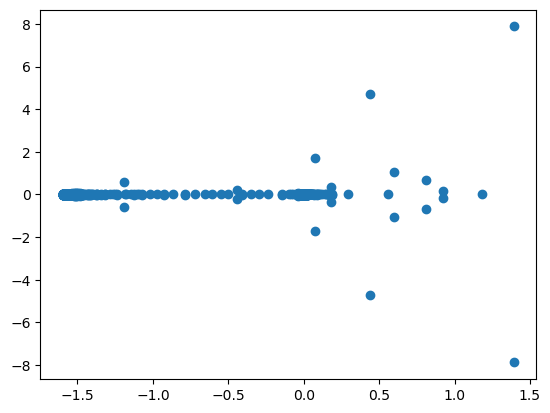

In [48]:
vals, vecs = np.linalg.eig(operator)
plt.scatter(np.real(vals), np.imag(vals))